In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

from utilities import plot_cm

### Prepare Loaders

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

### Load Data

In [9]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [10]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

In [11]:
sr = 16000
file_length = 64000
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

### Load Network

In [12]:
from CNNetworks2D import malley_cnn_80
from tensorflow.keras.optimizers import Adam

In [13]:
input_shape = ([n_mels,frames])
lr = 0.001
mc_model = malley_cnn_80(input_shape,n_meta_classes)
mc_model.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
#mc_model.save_weights('./weights_mc_malley.h5')
mc_model.load_weights('./weights_mc_malley_v3.h5')
#mc_model.summary()

### Make Inference

In [14]:
from utilities import create_quick_test

In [15]:
x_test_2 = create_quick_test(x_test,1600,80,125)

In [16]:
mc_model.evaluate(x_test_2,meta_labels_test)

1600/1600 [==============================] - 2s 972us/step


[0.40015264496207237, 0.916875]

In [17]:
y_scores_MC = mc_model.predict(x_test_2)

In [18]:
y_hat_MC = np.argmax(y_scores_MC, axis = 1)

### Plot Confusion Matrix

In [19]:
from utilities import plot_cm

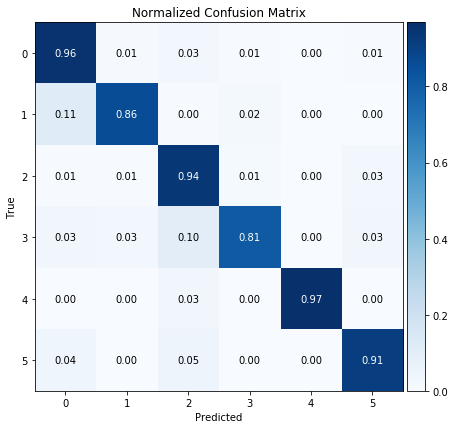

In [20]:
plot_cm(meta_labels_test,y_hat_MC,figsize = (7,7))

In [21]:
del(mc_model)

### Separate Given Inference

In [22]:
c0_indx = [i for i,f in enumerate(y_scores_MC) if f[0] >= 0.2]
c1_indx = [i for i,f in enumerate(y_scores_MC) if f[1] >= 0.2]
c2_indx = [i for i,f in enumerate(y_scores_MC) if f[2] >= 0.2]
c3_indx = [i for i,f in enumerate(y_scores_MC) if f[3] >= 0.2]
c4_indx = [i for i,f in enumerate(y_scores_MC) if f[4] >= 0.2]
c5_indx = [i for i,f in enumerate(y_scores_MC) if f[5] >= 0.2]

### Create General Class Vector

In [23]:
all_scores =np.zeros((1600,47))

### Cluster 0 

In [24]:
x0 = [x_test[f] for f in c0_indx]
y0 = [labels_test[f] for f in c0_indx]

In [25]:
with open('./c0_mapping', 'rb') as fp:
    c0_label_mapping = pickle.load(fp)
    
c0_label_mapping_inv = dict([[v,k] for [k,v] in c0_label_mapping.items()])
c0_label_mapping_inv[len(c0_label_mapping_inv)] = 41

c0_labels = list(c0_label_mapping.keys())

In [26]:
y0_2 = []

for f in y0:
    if f in c0_labels:
        y0_2.append(c0_label_mapping[f])
    else:
        y0_2.append(len(c0_labels))

In [27]:
modelc0 = malley_cnn_80((80,125),len(c0_label_mapping)+1)
modelc0.load_weights('./weights_c0_malley_v2.h5')
modelc0.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [28]:
x0_2 = create_quick_test(x0,len(x0),80,125)
modelc0.evaluate(x0_2,y0_2)

417/417 [==============================] - 0s 821us/step


[0.9149666411413563, 0.7817745803357314]

### Save Scores in General Scores

In [29]:
y_scores_c0 = modelc0.predict(x0_2)
y_hat_c0 = np.argmax(y_scores_c0,axis = 1)

In [30]:
y_hat_c0_orig = [c0_label_mapping_inv[f] for f in y_hat_c0]

In [31]:
edo = y_scores_c0[0]

In [32]:
edo[-1]

1.8975518e-07

In [33]:
for i,this_scores in zip(c0_indx,y_scores_c0):
    for j,f in enumerate(this_scores):
        all_scores[i,c0_label_mapping_inv[j]] = f * (1-this_scores[-1])#*y_scores_MC[i][0]

In [34]:
labels = [num_to_label[f] for f in c0_labels]
labels.append('Unknown')

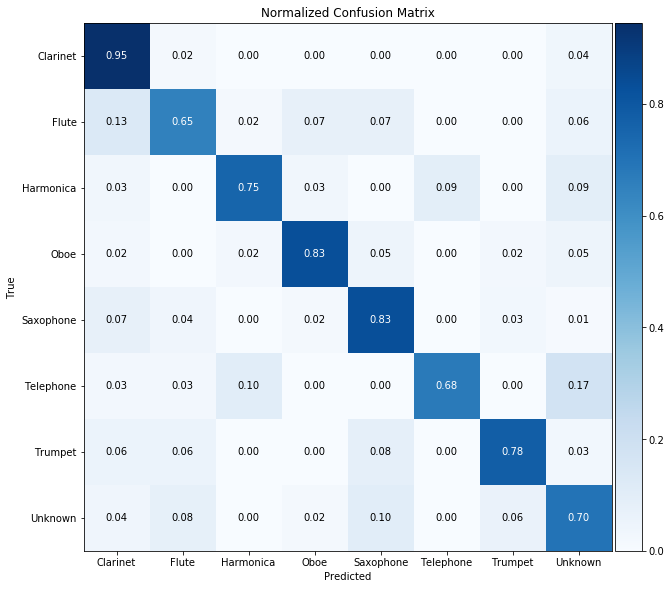

In [35]:
plot_cm(y0_2,y_hat_c0,figsize = (10,10), labels = labels)
plt.savefig('./cm_MC0.eps')
del(modelc0)

### Cluster 1

In [36]:
x1 = [x_test[f] for f in c1_indx]
y1 = [labels_test[f] for f in c1_indx]

In [37]:
with open('./c1_mapping', 'rb') as fp:
    c1_label_mapping = pickle.load(fp)

c1_label_mapping_inv = dict([[v,k] for [k,v] in c1_label_mapping.items()])
c1_label_mapping_inv[len(c1_label_mapping_inv)] = 42
    
c1_labels = list(c1_label_mapping.keys())

In [38]:
y1_2 = []

for f in y1:
    if f in c1_labels:
        y1_2.append(c1_label_mapping[f])
    else:
        y1_2.append(len(c1_labels))

In [39]:
modelc1 = malley_cnn_80((80,125),len(c1_labels)+1)
modelc1.load_weights('./weights_c1_malley_v2.h5')
modelc1.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [40]:
x1_2 = create_quick_test(x1,len(x1),80,125)
modelc1.evaluate(x1_2,y1_2)

199/199 [==============================] - 0s 1ms/step


[0.5461880590148906, 0.8743718595960033]

### Save Scores in General Scores

In [41]:
y_scores_c1 = modelc1.predict(x1_2)
y_hat_c1 = np.argmax(y_scores_c1,axis = 1)

In [42]:
y_hat_c1_orig = [c1_label_mapping_inv[f] for f in y_hat_c1]

In [43]:
for i,this_scores in zip(c1_indx,y_scores_c1):
    for j,f in enumerate(this_scores):
        all_scores[i,c1_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][1]

In [44]:
labels = [num_to_label[f] for f in c1_labels]
labels.append('Unknown')

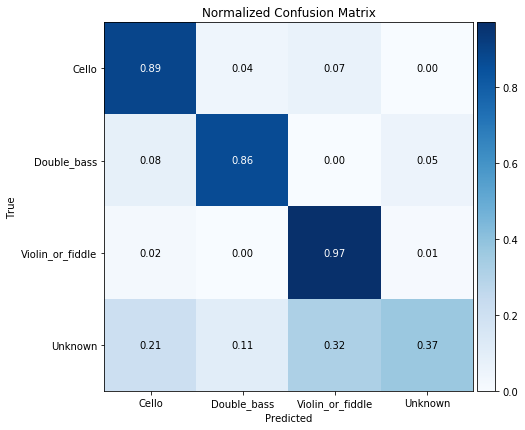

In [45]:
plot_cm(y1_2,y_hat_c1,figsize = (7,7), labels = labels)
plt.savefig('./cm_MC1.eps')

del(modelc1)

### Cluster 2

In [46]:
x2 = [x_test[f] for f in c2_indx]
y2 = [labels_test[f] for f in c2_indx]

In [47]:
with open('./c2_mapping', 'rb') as fp:
    c2_label_mapping = pickle.load(fp)
    
c2_label_mapping_inv = dict([[v,k] for [k,v] in c2_label_mapping.items()])
c2_label_mapping_inv[len(c2_label_mapping_inv)] = 43
    
c2_labels = list(c2_label_mapping.keys())

In [48]:
y2_2 = []

for f in y2:
    if f in c2_labels:
        y2_2.append(c2_label_mapping[f])
    else:
        y2_2.append(len(c2_labels))

In [49]:
modelc2 = malley_cnn_80((80,125),len(c2_labels)+1)
modelc2.load_weights('./weights_c2_malley.h5')
modelc2.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [50]:
x2_2 = create_quick_test(x2,len(x2),80,125)
modelc2.evaluate(x2_2,y2_2)

695/695 [==============================] - 1s 859us/step


[1.5505229195244878, 0.7179856119396018]

### Save Scores in General Scores

In [51]:
y_scores_c2 = modelc2.predict(x2_2)
y_hat_c2 = np.argmax(y_scores_c2,axis = 1)

In [52]:
y_hat_c2_orig = [c2_label_mapping_inv[f] for f in y_hat_c2]

In [53]:
for i,this_scores in zip(c2_indx,y_scores_c2):
    for j,f in enumerate(this_scores):
        all_scores[i,c2_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][2]

In [54]:
labels = [num_to_label[f] for f in c2_labels]
labels.append('Unknown')

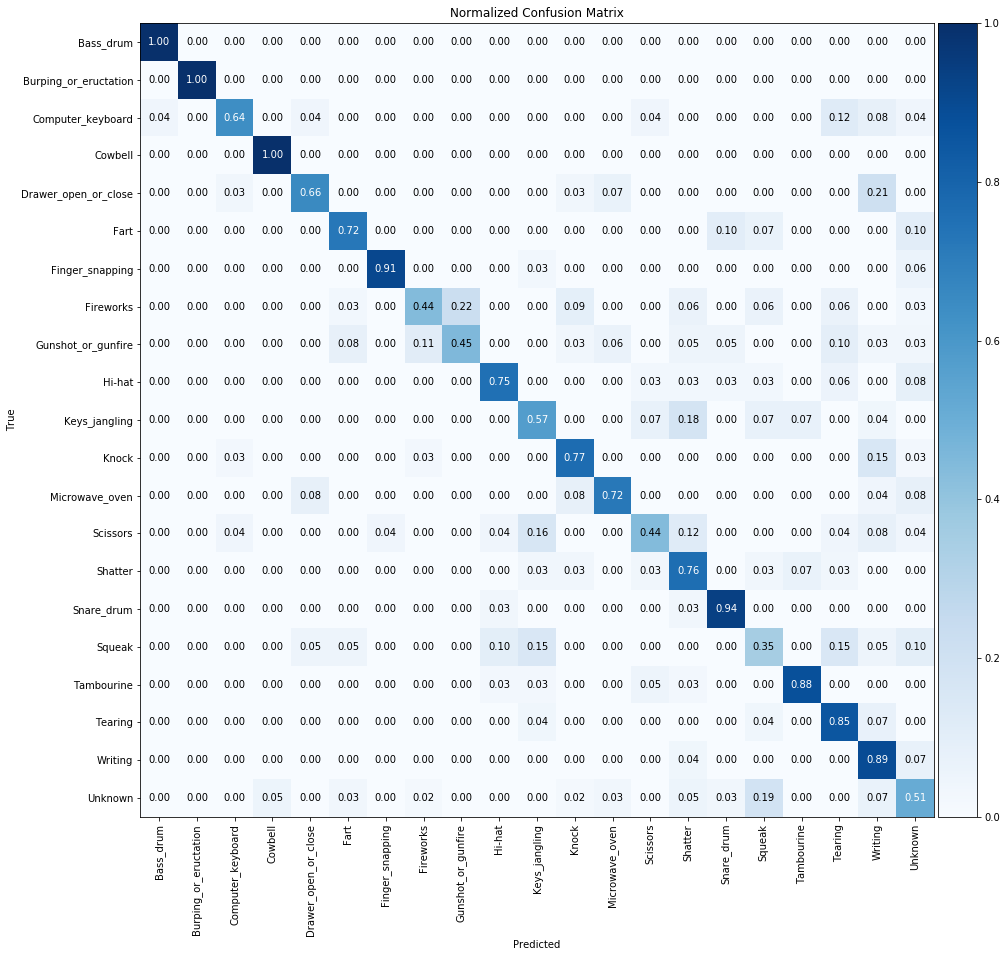

In [55]:
plot_cm(y2_2,y_hat_c2,figsize = (15,15), labels = labels, xrotation = 90)
plt.savefig('./cm_MC2.eps')

del(modelc2)

### Cluster 3

In [56]:
x3 = [x_test[f] for f in c3_indx]
y3 = [labels_test[f] for f in c3_indx]

In [57]:
with open('./c3_mapping', 'rb') as fp:
    c3_label_mapping = pickle.load(fp)
    
c3_label_mapping_inv = dict([[v,k] for [k,v] in c3_label_mapping.items()])
c3_label_mapping_inv[len(c3_label_mapping_inv)] = 44
    
c3_labels = list(c3_label_mapping.keys())

In [58]:
y3_2 = []

for f in y3:
    if f in c3_labels:
        y3_2.append(c3_label_mapping[f])
    else:
        y3_2.append(len(c3_labels))

In [59]:
modelc3 = malley_cnn_80((80,125),len(c3_labels)+1)
modelc3.load_weights('./weights_c3_malley.h5')
modelc3.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [60]:
x3_2 = create_quick_test(x3,len(x3),80,125)
modelc3.evaluate(x3_2,y3_2)

198/198 [==============================] - 0s 1ms/step


[1.4580027744023487, 0.686868687470754]

### Save Scores in General Scores

In [61]:
y_scores_c3 = modelc3.predict(x3_2)
y_hat_c3 = np.argmax(y_scores_c3,axis = 1)

In [62]:
y_hat_c3_orig = [c3_label_mapping_inv[f] for f in y_hat_c3]

In [63]:
for i,this_scores in zip(c3_indx,y_scores_c3):
    for j,f in enumerate(this_scores):
        all_scores[i,c3_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][3]

In [64]:
labels = [num_to_label[f] for f in c3_labels]
labels.append('Unknown')

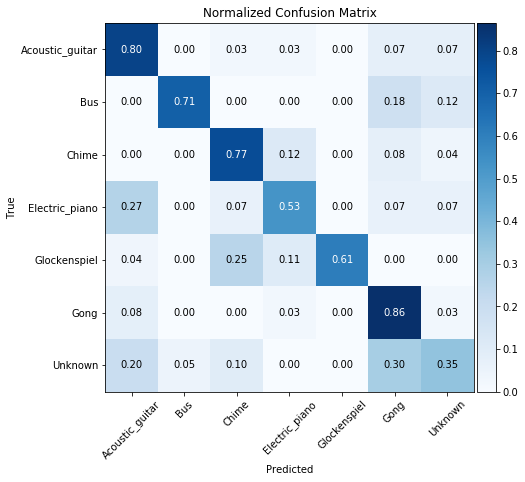

In [65]:
plot_cm(y3_2,y_hat_c3,figsize = (7,7), labels = labels, xrotation = 45)
plt.savefig('./cm_MC3.eps')

del(modelc3)

### Cluster 4

In [66]:
x4 = [x_test[f] for f in c4_indx]
y4 = [labels_test[f] for f in c4_indx]

In [67]:
y_hat_MC

array([0, 2, 0, ..., 2, 5, 0])

In [68]:
c4_scores = [f[4] for i,f in enumerate(y_scores_MC) if i in c4_indx]

In [69]:
for i, score in zip(c4_indx,c4_scores):
    all_scores[i,label_to_num['Applause']] = score

### Cluster 5

In [70]:
x5 = [x_test[f] for f in c5_indx]
y5 = [labels_test[f] for f in c5_indx]

In [71]:
with open('./c5_mapping', 'rb') as fp:
    c5_label_mapping = pickle.load(fp)

c5_label_mapping_inv = dict([[v,k] for [k,v] in c5_label_mapping.items()])
c5_label_mapping_inv[len(c5_label_mapping_inv)] = 45
    
c5_labels = list(c5_label_mapping.keys())

In [72]:
c5_labels = list(c5_label_mapping.keys())

In [73]:
y5_2 = []

for f in y5:
    if f in c5_labels:
        y5_2.append(c5_label_mapping[f])
    else:
        y5_2.append(len(c5_labels))

In [74]:
modelc5 = malley_cnn_80((80,125),len(c5_labels)+1)
modelc5.load_weights('./weights_c5_malley.h5')
modelc5.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [75]:
x5_2 = create_quick_test(x5,len(x5),80,125)
modelc5.evaluate(x5_2,y5_2)

154/154 [==============================] - 0s 2ms/step


[0.7568795355883512, 0.8311688280724859]

### Save Scores in General Scores

In [76]:
y_scores_c5 = modelc5.predict(x5_2)
y_hat_c5 = np.argmax(y_scores_c5,axis = 1)

In [77]:
y_hat_c5_orig = [c5_label_mapping_inv[f] for f in y_hat_c5]

In [78]:
for i,this_scores in zip(c5_indx,y_scores_c5):
    for j,f in enumerate(this_scores):
        all_scores[i,c5_label_mapping_inv[j]] = f * (1-this_scores[-1])#y_scores_MC[i][5]

In [79]:
labels = [num_to_label[f] for f in c5_labels]
labels.append('Unknown')

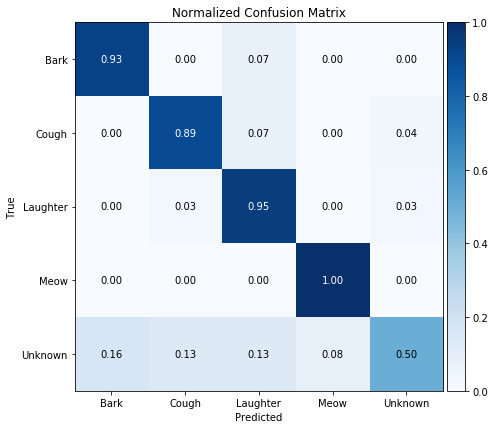

In [80]:
plot_cm(y5_2,y_hat_c5,figsize = (7,7), labels = labels)
plt.savefig('./cm_MC5.eps')

del(modelc5)

### Final Inference

In [81]:
y_hat_final = np.argmax(all_scores[:,:41],axis = 1)

In [82]:
np.mean(y_hat_final==labels_test)

0.758125

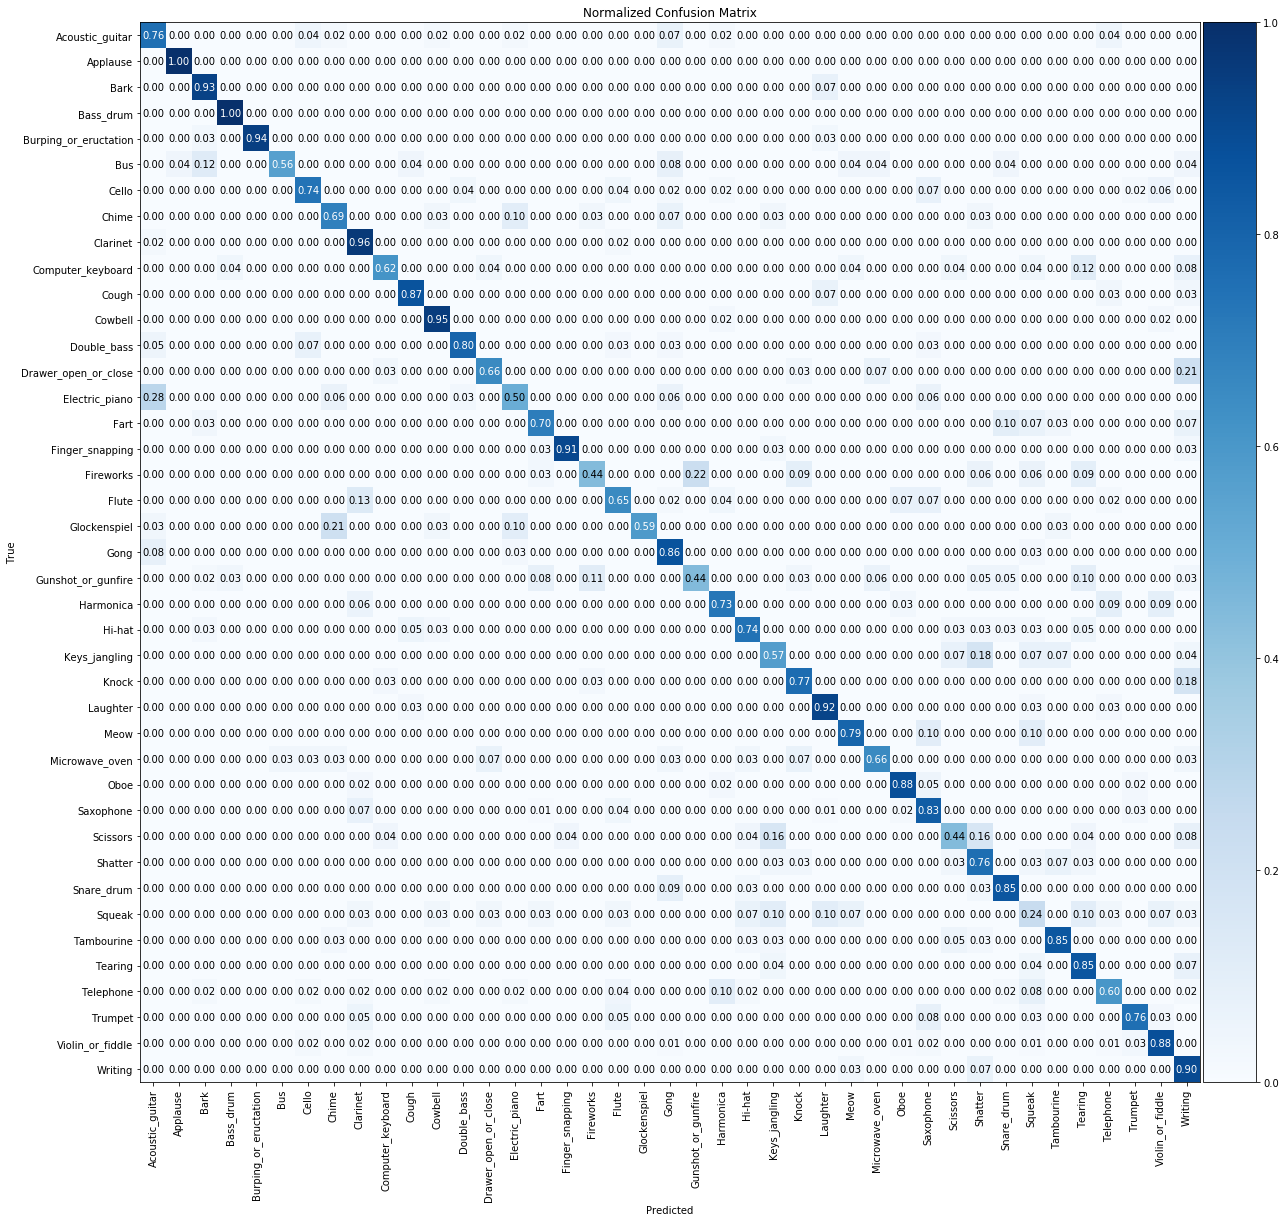

In [83]:
labels = list(num_to_label.values())
plot_cm(labels_test,y_hat_final,figsize = (20,20), labels = labels, xrotation=90)
plt.savefig('./cm_all_41classes.eps')